In [197]:
import sys
sys.path.append('../../')
from Backtest import Backtest,Position,Bid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
import pickle
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

In [49]:
with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

In [264]:
data = get_data(tickers,'1440d','1d')
data

[*********************100%***********************]  100 of 100 completed


,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-20,45.672226,67.746773,75.681824,158.183151,259.739990,38.793434,172.204117,177.789703,89.863503,256.562775,...,237.594421,149.610031,97.356346,44.043072,150.371964,48.581097,54.631924,45.600048,93.002434,66.370697
2019-03-21,47.354351,68.429031,75.795418,160.057327,264.179993,39.217854,172.897919,180.732117,90.962997,261.649475,...,239.036118,151.106125,99.052322,43.422249,152.376892,49.103382,55.336678,45.111481,93.398430,66.754311
2019-03-22,46.373718,67.182434,73.816757,157.203232,259.690002,38.486412,168.221588,179.748199,88.238503,257.990906,...,234.360092,149.256912,96.842148,42.215588,149.706894,50.341709,54.301300,43.709095,92.663017,65.685112
2019-03-25,45.813007,66.971855,74.062904,157.051025,262.269989,38.332901,168.122498,181.641724,88.712997,257.558990,...,234.141937,150.074661,96.436195,42.058193,149.667786,50.611286,53.674835,43.501003,92.559303,65.228058
2019-03-26,45.339687,68.024742,74.791870,158.820572,265.589996,38.874706,169.636185,181.047684,89.188004,261.852234,...,230.850723,150.362717,97.798401,42.416702,151.887878,51.074596,53.874958,44.342430,92.700722,66.076881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.199997,134.210007,96.760002,257.299988,275.200012,47.480000,225.399994,213.145813,113.000000,444.010010,...,505.040009,194.820007,161.539993,40.320000,177.649994,37.340702,31.400000,40.220001,129.699997,87.309998
2022-10-03,142.449997,138.320007,99.519997,264.890015,285.239990,49.180000,230.440002,215.597931,115.879997,456.779999,...,515.510010,200.259995,163.089996,41.570000,181.649994,38.510979,32.430000,41.580002,132.529999,91.919998
2022-10-04,146.100006,141.990005,103.080002,274.309998,294.970001,51.709999,233.020004,218.486877,121.089996,479.859985,...,523.169983,205.380005,168.889999,42.630001,185.649994,39.150208,33.389999,43.540001,134.250000,95.269997


In [288]:
class EXP3:
    def __init__(self,data,gamma):
        self.data = data.pct_change()
        self.tickers = self.data.columns
        self.data.columns = [i for i in range(len(self.tickers))]
        self.num_actions = len(self.data.columns)
        self.gamma = gamma
        self.weights = [1]*self.num_actions
        
        self.ProbabilityDistr = []
        self.regrets = []
        self.current_hold = -1
        self.rewards = []
        self.gammas = []
    #get current distribution
    def get_distr(self):        
        theSum = float(sum(self.weights))
        return tuple((1.0 - self.gamma) * (w / theSum) + (self.gamma / len(self.weights)) for w in self.weights)
    
    
    #draw an action from distribution
    def draw(self,weights):
        choice = random.uniform(0, sum(weights))
        choiceIndex = 0
        for weight in weights:
            choice -= weight
            if choice <= 0:
                return choiceIndex
            choiceIndex += 1
    
    def reset(self):
        self.rewards = []
        self.weights = [1]*self.num_actions
    
    def predict(self,ti,df,positions,cash,full_data):
        bid_list = []
        #sell the previous one
        
        for pos in positions.values():
            ticker = pos.ticker
            price = df.iloc[-1][pos.ticker]
            shares_held = pos.shares
            
            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)
            
            cash += shares_held*price
            

            

        if self.current_hold != -1:
            #reward
            reward = self.data.loc[ti,self.current_hold]
            
            #scaled_reward
            min_ret = min(self.data.loc[ti])
            max_ret = max(self.data.loc[ti])
            mean_ret = sum(self.data.loc[ti])/len(self.data.loc[ti])

            scaled_reward = (reward-mean_ret)/(max_ret-min_ret)
            regret = (max_ret-reward)/(max_ret-min_ret)
            self.regrets.append(regret)
            
            self.rewards.append(scaled_reward)
            #esitimated_reward
            
            estimatedReward = 1.0 * scaled_reward / self.ProbabilityDistr[-1][self.current_hold]
            self.weights[self.current_hold] *= np.exp(estimatedReward * self.gamma / self.num_actions)
        
        #take another action
        ProbabilityDistribution = self.get_distr()
        self.ProbabilityDistr.append(ProbabilityDistribution)
        choice = self.draw(ProbabilityDistribution)
        ticker = self.tickers[choice]
        price = df.iloc[-1][ticker]
        shares = cash//price
        bid = Bid(ticker = ticker,shares = shares,price = price,bid_type = 1)
        bid_list.append(bid)
        self.current_hold = choice
        
        return bid_list


In [304]:
#data1 = data.iloc[:]
exp3 = EXP3(data,0.4)
exp3_bt = Backtest(data,exp3,has_tc = False)
exp3_bt.backtest_full()

<AxesSubplot:>

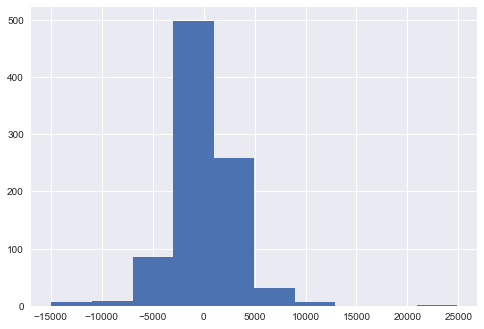

In [305]:
exp3_bt.transaction_history['pnl'][exp3_bt.transaction_history.type == 0].hist()

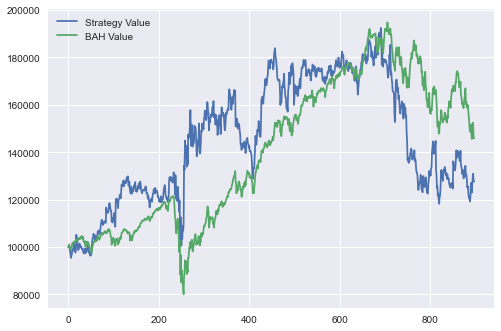

In [306]:
plt.style.use('seaborn')
exp3_bt.plot()

In [307]:
exp3_bt.portfolio_tracker['total_value'].pct_change().mean()/exp3_bt.portfolio_tracker['total_value'].pct_change().std()*(251**0.5)

0.36628326222188634